# Zoidberg 2.0

## Introduction

We were given a dataset of x-rays, which took around 20 minutes to install from their server. To speed things up and for convenience we sanitized the dataset and uploaded it to hugging face hub. We will see how fast and concise this solution turned out to be.

We outsourced the following data processing tasks to these files :

- [Finding the right image mask](./src/image_mask.ipynb)
- [Data preprocessing and saving in `.npz` file](./src/image_mask.ipynb)

Our goal with the dataset is to find the right machine learning model to help doctors in detecting pneumonia. We will proceed by pulling the `train` split of the dataset (as you can see with the `split="train"` parameter).


We will begin by loading the **preprocessed** dataset from the file.


In [1]:
import numpy as np

processed_data = np.load("./datasets/processed_data.npz", allow_pickle=True)

In [2]:
x_train = processed_data["x_train"]
y_train = processed_data["y_train"]
x_test = processed_data["x_test"]
y_test = processed_data["y_test"]
x_eval = processed_data["x_eval"]
y_eval = processed_data["y_eval"]

Then we will calculate the offset from the geometric center of each image of the training set using the following functions.


In [3]:
from scipy.ndimage import center_of_mass
import math


def get_center_of_mass(image):
    """
    Calculate the center of mass of a binary image.

    This function takes a binary image as input, where foreground pixels are represented as True (or 1)
    and background pixels are represented as False (or 0). It then computes the center of mass (COM)
    of the binary image, which represents the average position of all the foreground pixels.

    Parameters:
    - image: numpy.ndarray
        The input binary image represented as a NumPy array.

    Returns:
    - center: tuple
        A tuple containing the coordinates (row, column) of the center of mass of the binary image.
        The row and column indices start from 0.

    Note:
    - The input image should be a binary image where foreground pixels are represented by True (or 1) and
      background pixels are represented by False (or 0).
    - The center of mass is computed using the center_of_mass function from the scipy.ndimage module.
      Make sure to import this function before using get_center_of_mass.
    """
    binary_image = np.array(image) > 128
    com = center_of_mass(binary_image)
    return (0, 0) if np.isnan(com).any() else com


def calculate_offset(image):
    """
    Calculate the offset between the center of mass (COM) and the geometric center of a binary image.

    Parameters:
    - image: numpy.ndarray
        The input binary image represented as a NumPy array.

    Returns:
    - offset: numpy.ndarray
        A NumPy array representing the offset between the center of mass and the geometric center.
        The offset is computed as the center of mass (COM) minus the geometric center.
        The offset has the same dimensionality as the input image.

    Note:
    - The geometric center is computed as the center of the image grid, which is assumed to be at the
      half width and half height of the image.
    - The offset indicates the displacement of the center of mass relative to the geometric center.
    """

    com = get_center_of_mass(image)

    image = np.array(image)

    geometric_center = np.array(image.shape) / 2

    # print(geometric_center)

    offset = geometric_center - com

    # Check for NaN in the tuple
    if any(math.isnan(x) for x in offset):
        raise Exception("nan found")

    return offset

In [4]:
offsets = [calculate_offset(img) for img in x_train]

mean x offset :  -0.2115543586369692
mean y offset :  -8.841938914011743


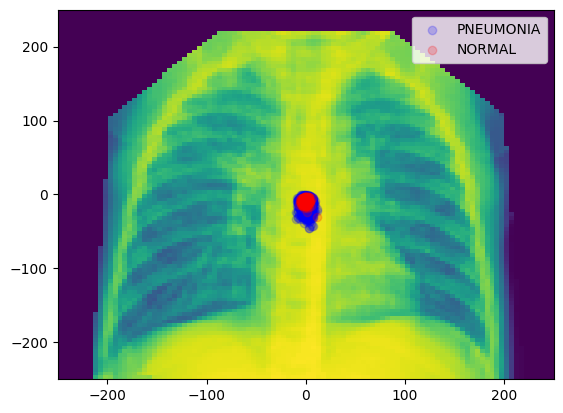

In [7]:
from matplotlib import pyplot as plt
import random

x_offsets = np.array([offset[1] for offset in offsets])
y_offsets = np.array([offset[0] for offset in offsets])
x_offsets_normal = x_offsets[y_train == 0]
x_offsets_pneumonia = x_offsets[y_train == 1]
y_offsets_normal = y_offsets[y_train == 0]
y_offsets_pneumonia = y_offsets[y_train == 1]

print("mean x offset : ", np.mean(x_offsets))
print("mean y offset : ", np.mean(y_offsets))


extent = [-500 / 2, 500 / 2, -500 / 2, 500 / 2]

# Display the image with the calculated extents
plt.imshow(x_train[int(random.random() * len(x_train))], extent=extent, aspect="auto")
plt.scatter(
    x_offsets_pneumonia, y_offsets_pneumonia, color="blue", alpha=0.2, label="PNEUMONIA"
)
plt.scatter(x_offsets_normal, y_offsets_normal, color="red", alpha=0.2, label="NORMAL")

plt.legend()
plt.show()

We can notice that on the y axis, the points are pulled towards the bottom which can be explained because of the the visible **pelvis bone** in some of the images resulting in a pull of the **center of mass** towards it.

What's also interesting and can be deduced, is how the images of `NORMAL` patients have a more grouped and centered **center of mass** compared to the patients with `PNEUMONIA`.


## Dimension Reduction

We will first do a **Principal Component Analysis** (`PCA`) to reduce the dimensionality of the images, and then we will plot the first two `PCA`s and then the third in a 3-D plot.

> **NOTE:** This might take a few minutes depending on your hardware, but it's totally worth it


> **NOTE 2:** To cut on wait times set `n_components` to `0.8` it will keep $80\%$ of the dataset's information.


> **NOTE 3:** We will demonstrate why `0.8` [here](#comparing-classification-results-with-different-n_components)


> **NOTE 4:** If you already have the resulting numpy array stored in a file you can skip this step and the following analysis and move to [model discovery](#model-discovery)


In [8]:
# The following function will flatten the images to vectors
# It will also normalized their values (between 0 and 1)
def normalize_images(images):
    return np.array([np.asarray(img).ravel() / 255.0 for img in images])

In [10]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.8)

x_train_pca = pca.fit_transform(normalize_images(x_train))
np.save("./datasets/x_train_pca", x_train_pca)

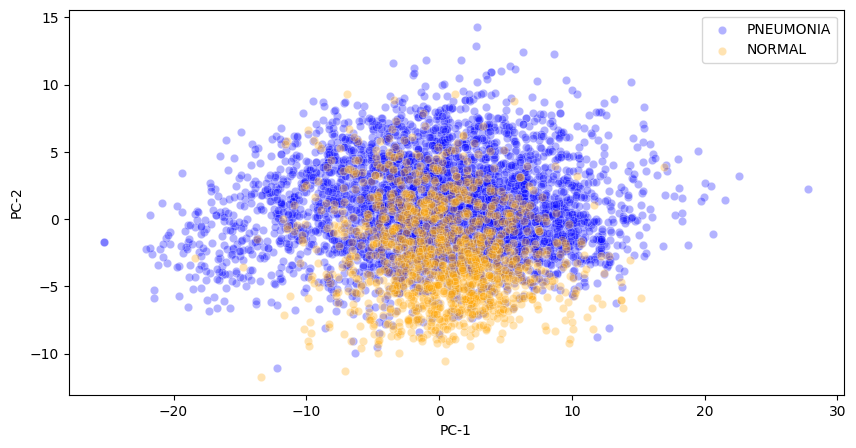

In [17]:
%matplotlib inline
import seaborn as sns

plt.figure(figsize=(10, 5))
sns.scatterplot(x=x_train_pca[y_train == 1, 0], y=x_train_pca[y_train == 1, 1], color="blue", label="PNEUMONIA", alpha=0.3)
sns.scatterplot(x=x_train_pca[y_train == 0, 0], y=x_train_pca[y_train == 0, 1], color="orange", label="NORMAL", alpha=0.3)
plt.xlabel("PC-1"), plt.ylabel("PC-2")
plt.show()

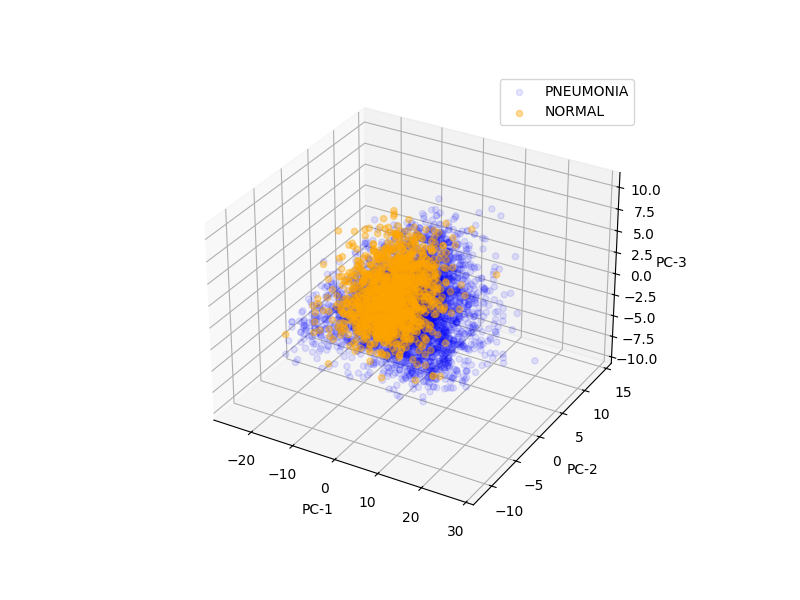

In [22]:
%matplotlib widget

# Assuming X_3d is your 3D data array and labels is your corresponding labels array
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection="3d")

ax.scatter(
    x_train_pca[y_train == 1, 0],
    x_train_pca[y_train == 1, 1],
    x_train_pca[y_train == 1, 2],
    color="blue",
    label="PNEUMONIA",
    alpha=0.1
)

ax.scatter(
    x_train_pca[y_train == 0, 0],
    x_train_pca[y_train == 0, 1],
    x_train_pca[y_train == 0, 2],
    color="orange",
    label="NORMAL",
    alpha=0.4
)

ax.set_xlabel('PC-1')
ax.set_ylabel('PC-2')
ax.set_zlabel('PC-3')

plt.legend()
plt.show()